# Example1: Principal Component Analysis (PCA) 


Principal Component Analysis (PCA) is a classic statistical technique for dimensionality reduction. It defines a mapping between the $d$-dimensional data-representation of a point $\boldsymbol{x}$ and its $k$-dimensional latent representation, $\boldsymbol{z}$. The latent representation is known as the scores, and the affine transformation is performed using the loading matrix $\boldsymbol{\beta}$, which has dimensions $k\times d$. 


A simplified probabilistic view of PCA (Tipping & Bishop, 1999) is given below, which provides a pseudo-code a description of the generative model of a probabilistic PCA model.

<img src="https://raw.githubusercontent.com/PGM-Lab/ProbModelingDNNs/master/img/pca_pseudocode.png" alt="PCA-pseudocode" style="width: 700px;"/>


The present notebook experimentally illustrates the behavior of Probabilistic PCA as a feature reduction method on (a reduced version of) MNIST dataset. The model is implemented using the InferPy.

## Setting up the system

First, we will install and import the required packages as follows.



In [ ]:
!pip install tensorflow==1.14.0
!pip install tensorflow-probability==0.7.0
!pip install keras
!pip install matplotlib
!pip install inferpy==1.2.0
!pip install setuptools
!pip install pandas

In [2]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import pandas as pd
import sys

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore")

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01



Using TensorFlow backend.


## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

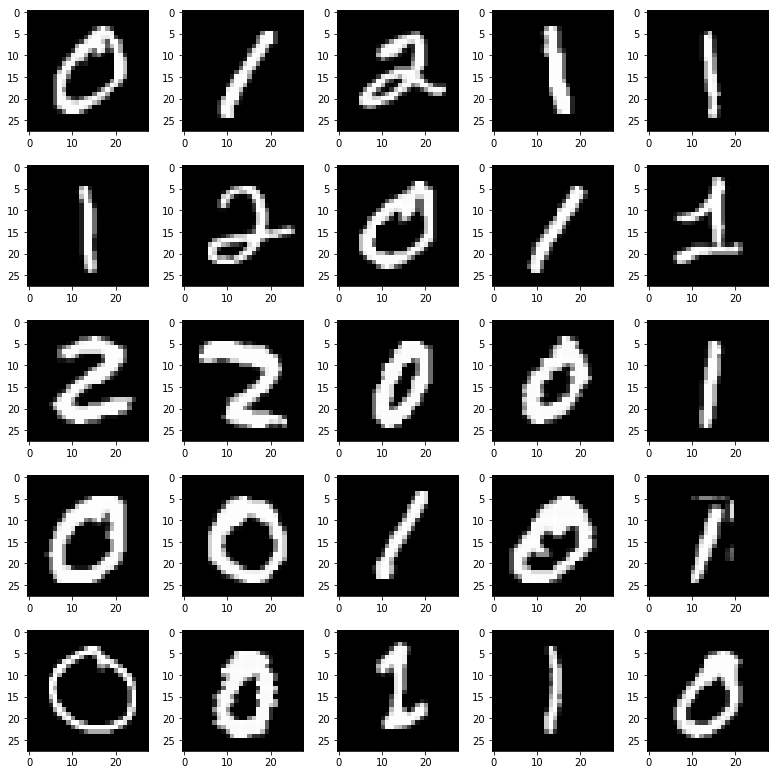

In [3]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

## Model definition

The implementation for the generative model for a PCA model (Algorithm 1) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [4]:
# Model constants
k, d = 2, np.shape(x_train)[-1]

@inf.probmodel
def pca(k,d):
    w = inf.Normal(loc=tf.zeros([k,d]),
                   scale=1, name="w")               # shape = [k,d]
    w0 = inf.Normal(loc=tf.zeros([d]),
                    scale=1, name="w0")  # shape = [d]
    with inf.datamodel():
        z = inf.Normal(tf.zeros([k]),1, name="z")       # shape = [N,k]
        x = inf.Normal( z @ w + w0, 1, name="x")         # shape = [N,d]



print(pca)

<function pca at 0x13796ce18>


This is a latent variable model (LVM) where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using the loading matrix  $\boldsymbol{\beta}$.

## Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [5]:
@inf.probmodel
def Q(k,d):
    qw_loc = inf.Parameter(tf.zeros([k,d]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([k,d]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

    qw0_loc = inf.Parameter(tf.ones([d]), name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(tf.ones([d]), name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")
    
    with inf.datamodel():
        qz_loc = inf.Parameter(np.zeros([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(qz_loc, qz_scale, name="z")

print(Q)

<function Q at 0x13ea32f28>


Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\phi})  = \mathbb{E}_q [\ln p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{\beta})] - \mathbb{E}_q [\ln q(\boldsymbol{\beta},\boldsymbol{z}|\boldsymbol{\lambda},\boldsymbol{\phi})]$

In InferPy, this is transparent to the user: it is only required to create the instances of the P and Q models, the optimizer and inference method objects.

In [6]:
# create an instance of the P model and the Q model
m = pca(k,d)
q = Q(k,d)

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=2000)

W0916 16:22:59.776368 4562855360 deprecation_wrapper.py:119] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/inferpy/models/prob_model.py:63: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0916 16:22:59.798712 4562855360 deprecation_wrapper.py:119] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/inferpy/models/random_variable.py:420: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W0916 16:22:59.833034 4562855360 deprecation_wrapper.py:119] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 16:22:59.943487 4562855360 deprecation_wrapper.py:119] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/inferpy/models/prob_model.py:136: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


Finally, the ELBO function is maximized.

In [7]:
m.fit({"x": x_train}, VI)        

W0916 16:23:00.790354 4562855360 deprecation.py:323] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/inferpy/util/interceptor.py:21: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
W0916 16:23:01.481358 4562855360 deprecation.py:323] From /Users/rcabanas/venv/InferPy/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



 0 epochs	 2878731008.0....................
 200 epochs	 2508015104.0....................
 400 epochs	 1888004736.0....................
 600 epochs	 1659253888.0....................
 800 epochs	 1602698880.0....................
 1000 epochs	 1584020992.0....................
 1200 epochs	 1567928576.0....................
 1400 epochs	 1507414400.0....................
 1600 epochs	 1392645248.0....................
 1800 epochs	 1321298816.0....................

After the inference, we can plot the hidden representation:

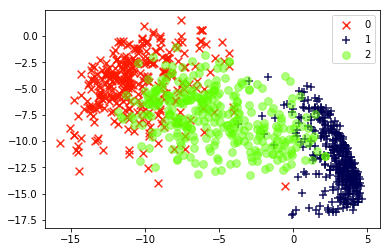

In [8]:
post = {"z": m.posterior("z", data={"x": x_train}).sample()}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

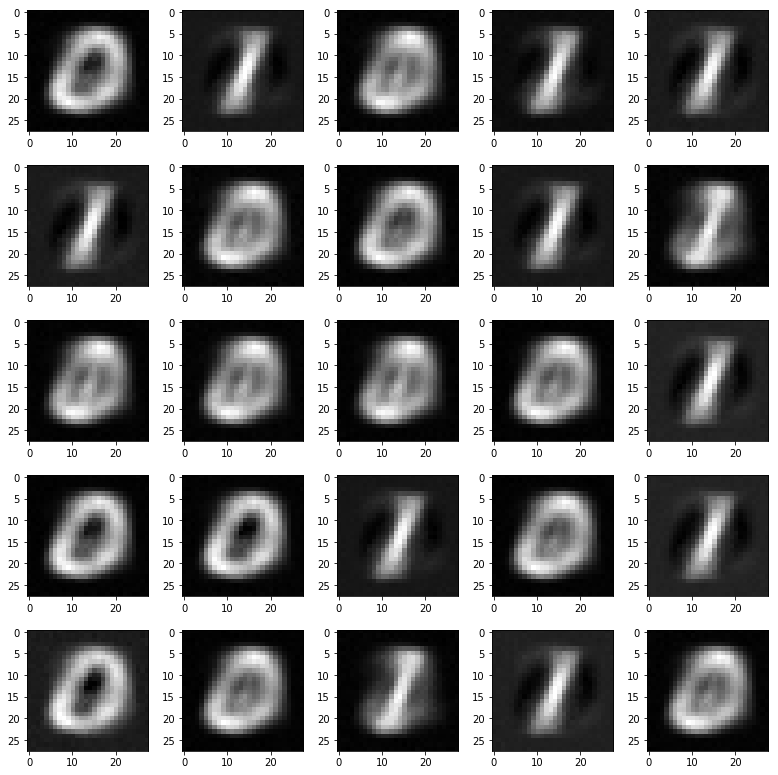

In [9]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])